In [13]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
import random
sns.set()

In [14]:
import pkg_resources
import types


def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            name = val.__name__.split('.')[0]
        elif isinstance(val, type):
            name = val.__module__.split('.')[0]
        poorly_named_packages = {'PIL': 'Pillow', 'sklearn': 'scikit-learn'}
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]
        yield name


imports = list(set(get_imports()))
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name != 'pip':
        requirements.append((m.project_name, m.version))

for r in requirements:
    print('{}=={}'.format(*r))

seaborn==0.13.2
pandas==2.2.2
numpy==1.26.4
matplotlib==3.9.1


In [15]:
def get_state(data, t, n):
    d = t - n + 1
    block = data[d : t + 1] if d >= 0 else -d * [data[0]] + data[0 : t + 1]
    res = []
    for i in range(n - 1):
        res.append(block[i + 1] - block[i])
    return np.array([res])

TSLA

In [16]:
df = pd.read_csv('../dataset/TSLA.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2022-09-30,266.149994,275.570007,262.470001,265.250000,265.250000,67726600
1,2022-10-03,254.500000,255.160004,241.009995,242.399994,242.399994,98363500
2,2022-10-04,250.520004,257.500000,242.009995,249.440002,249.440002,109578500
3,2022-10-05,245.009995,246.669998,233.270004,240.809998,240.809998,86982700
4,2022-10-06,239.440002,244.580002,235.350006,238.130005,238.130005,69298400


In [17]:
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
497,2024-09-24,254.080002,257.190002,249.050003,254.270004,254.270004,88491000
498,2024-09-25,252.539993,257.049988,252.279999,257.019989,257.019989,65034300
499,2024-09-26,260.600006,261.750000,251.529999,254.220001,254.220001,67142200
500,2024-09-27,257.380005,260.700012,254.119995,260.459991,260.459991,70729000
501,2024-09-30,259.000000,264.859985,256.809998,259.359985,259.359985,55979587


In [18]:
close = df.Close.values.tolist()
window_size = 30
skip = 1
l = len(close) - 1

In [19]:
class Deep_Evolution_Strategy:

    inputs = None

    def __init__(
        self, weights, reward_function, population_size, sigma, learning_rate
    ):
        self.weights = weights
        self.reward_function = reward_function
        self.population_size = population_size
        self.sigma = sigma
        self.learning_rate = learning_rate

    def _get_weight_from_population(self, weights, population):
        weights_population = []
        for index, i in enumerate(population):
            jittered = self.sigma * i
            weights_population.append(weights[index] + jittered)
        return weights_population

    def get_weights(self):
        return self.weights

    def train(self, epoch = 100, print_every = 1):
        lasttime = time.time()
        for i in range(epoch):
            population = []
            rewards = np.zeros(self.population_size)
            for k in range(self.population_size):
                x = []
                for w in self.weights:
                    x.append(np.random.randn(*w.shape))
                population.append(x)
            for k in range(self.population_size):
                weights_population = self._get_weight_from_population(
                    self.weights, population[k]
                )
                rewards[k] = self.reward_function(weights_population)
            rewards = (rewards - np.mean(rewards)) / np.std(rewards)
            for index, w in enumerate(self.weights):
                A = np.array([p[index] for p in population])
                self.weights[index] = (
                    w
                    + self.learning_rate
                    / (self.population_size * self.sigma)
                    * np.dot(A.T, rewards).T
                )
            if (i + 1) % print_every == 0:
                print(
                    'iter %d. reward: %f'
                    % (i + 1, self.reward_function(self.weights))
                )
        print('time taken to train:', time.time() - lasttime, 'seconds')


class Model:
    def __init__(self, input_size, layer_size, output_size):
        self.weights = [
            np.random.randn(input_size, layer_size),
            np.random.randn(layer_size, output_size),
            np.random.randn(layer_size, 1),
            np.random.randn(1, layer_size),
        ]

    def predict(self, inputs):
        feed = np.dot(inputs, self.weights[0]) + self.weights[-1]
        decision = np.dot(feed, self.weights[1])
        buy = np.dot(feed, self.weights[2])
        return decision, buy

    def get_weights(self):
        return self.weights

    def set_weights(self, weights):
        self.weights = weights

In [20]:
class Agent:

    POPULATION_SIZE = 15
    SIGMA = 0.1
    LEARNING_RATE = 0.03

    def __init__(self, model, money, max_buy, max_sell):
        self.model = model
        self.initial_money = money
        self.max_buy = max_buy
        self.max_sell = max_sell
        self.es = Deep_Evolution_Strategy(
            self.model.get_weights(),
            self.get_reward,
            self.POPULATION_SIZE,
            self.SIGMA,
            self.LEARNING_RATE,
        )

    def act(self, sequence):
        decision, buy = self.model.predict(np.array(sequence))
        return np.argmax(decision[0]), int(buy[0])

    def get_reward(self, weights):
        initial_money = self.initial_money
        starting_money = initial_money
        self.model.weights = weights
        state = get_state(close, 0, window_size + 1)
        inventory = []
        quantity = 0
        for t in range(0, l, skip):
            action, buy = self.act(state)
            next_state = get_state(close, t + 1, window_size + 1)
            if action == 1 and initial_money >= close[t]:
                if buy < 0:
                    buy = 1
                if buy > self.max_buy:
                    buy_units = self.max_buy
                else:
                    buy_units = buy
                total_buy = buy_units * close[t]
                initial_money -= total_buy
                inventory.append(total_buy)
                quantity += buy_units
            elif action == 2 and len(inventory) > 0:
                if quantity > self.max_sell:
                    sell_units = self.max_sell
                else:
                    sell_units = quantity
                quantity -= sell_units
                total_sell = sell_units * close[t]
                initial_money += total_sell

            state = next_state
        return ((initial_money - starting_money) / starting_money) * 100

    def fit(self, iterations, checkpoint):
        self.es.train(iterations, print_every = checkpoint)

    def buy(self):
        initial_money = self.initial_money
        state = get_state(close, 0, window_size + 1)
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        quantity = 0
        for t in range(0, l, skip):
            action, buy = self.act(state)
            next_state = get_state(close, t + 1, window_size + 1)
            if action == 1 and initial_money >= close[t]:
                if buy < 0:
                    buy = 1
                if buy > self.max_buy:
                    buy_units = self.max_buy
                else:
                    buy_units = buy
                total_buy = buy_units * close[t]
                initial_money -= total_buy
                inventory.append(total_buy)
                quantity += buy_units
                states_buy.append(t)
                print(
                    'day %d: buy %d units at price %f, total balance %f'
                    % (t, buy_units, total_buy, initial_money)
                )
            elif action == 2 and len(inventory) > 0:
                bought_price = inventory.pop(0)
                if quantity > self.max_sell:
                    sell_units = self.max_sell
                else:
                    sell_units = quantity
                if sell_units < 1:
                    continue
                quantity -= sell_units
                total_sell = sell_units * close[t]
                initial_money += total_sell
                states_sell.append(t)
                try:
                    invest = ((total_sell - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell %d units at price %f, investment %f %%, total balance %f,'
                    % (t, sell_units, total_sell, invest, initial_money)
                )
            state = next_state

        invest = ((initial_money - starting_money) / starting_money) * 100
        print(
            '\ntotal gained %f, total investment %f %%'
            % (initial_money - starting_money, invest)
        )
        plt.figure(figsize = (20, 10))
        plt.plot(close, label = 'true close', c = 'g')
        plt.plot(
            close, 'X', label = 'predict buy', markevery = states_buy, c = 'b'
        )
        plt.plot(
            close, 'o', label = 'predict sell', markevery = states_sell, c = 'r'
        )
        plt.legend()
        plt.show()

In [21]:
model = Model(window_size, 500, 3)
agent = Agent(model, 10000, 5, 5)
agent.fit(500, 10)

/var/folders/9r/gpf3r8sd3f3db5vx30c720j80000gn/T/ipykernel_5172/857736872.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return np.argmax(decision[0]), int(buy[0])


iter 10. reward: 59.362704
iter 20. reward: 103.014405
iter 30. reward: 93.884601
iter 40. reward: 105.744002
iter 50. reward: 122.648701
iter 60. reward: 137.659498
iter 70. reward: 145.215302
iter 80. reward: 165.400402
iter 90. reward: 157.704803
iter 100. reward: 164.151600
iter 110. reward: 159.392002
iter 120. reward: 166.619403
iter 130. reward: 168.658305
iter 140. reward: 183.095906
iter 150. reward: 179.371908
iter 160. reward: 175.998105
iter 170. reward: 169.278302
iter 180. reward: 182.831701
iter 190. reward: 194.874705
iter 200. reward: 197.474501
iter 210. reward: 195.633504
iter 220. reward: 183.451902
iter 230. reward: 195.896905
iter 240. reward: 195.944202
iter 250. reward: 193.101102
iter 260. reward: 204.971202
iter 270. reward: 190.420898
iter 280. reward: 181.322000
iter 290. reward: 210.687200
iter 300. reward: 190.779401
iter 310. reward: 192.365802
iter 320. reward: 197.766801
iter 330. reward: 181.335201
iter 340. reward: 204.730502
iter 350. reward: 197.616

day 1: buy 1 units at price 242.399994, total balance 9757.600006
day 3, sell 1 units at price 240.809998, investment -0.655939 %, total balance 9998.410004,
day 5: buy 1 units at price 223.070007, total balance 9775.339996
day 10: buy 5 units at price 1024.950027, total balance 8750.389969
day 12: buy 1 units at price 220.190002, total balance 8530.199966
day 14: buy 1 units at price 207.279999, total balance 8322.919968
day 15: buy 5 units at price 1072.200012, total balance 7250.719955
day 16, sell 5 units at price 1056.250000, investment 373.506059 %, total balance 8306.969955,
day 18: buy 1 units at price 224.639999, total balance 8082.329956
day 20, sell 5 units at price 1142.600021, investment 11.478608 %, total balance 9224.929977,
day 21, sell 4 units at price 910.159973, investment 313.352088 %, total balance 10135.089951,
day 23: buy 1 units at price 214.979996, total balance 9920.109955
day 24: buy 5 units at price 1076.549988, total balance 8843.559967
day 25, sell 5 units

/var/folders/9r/gpf3r8sd3f3db5vx30c720j80000gn/T/ipykernel_5172/857736872.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return np.argmax(decision[0]), int(buy[0])


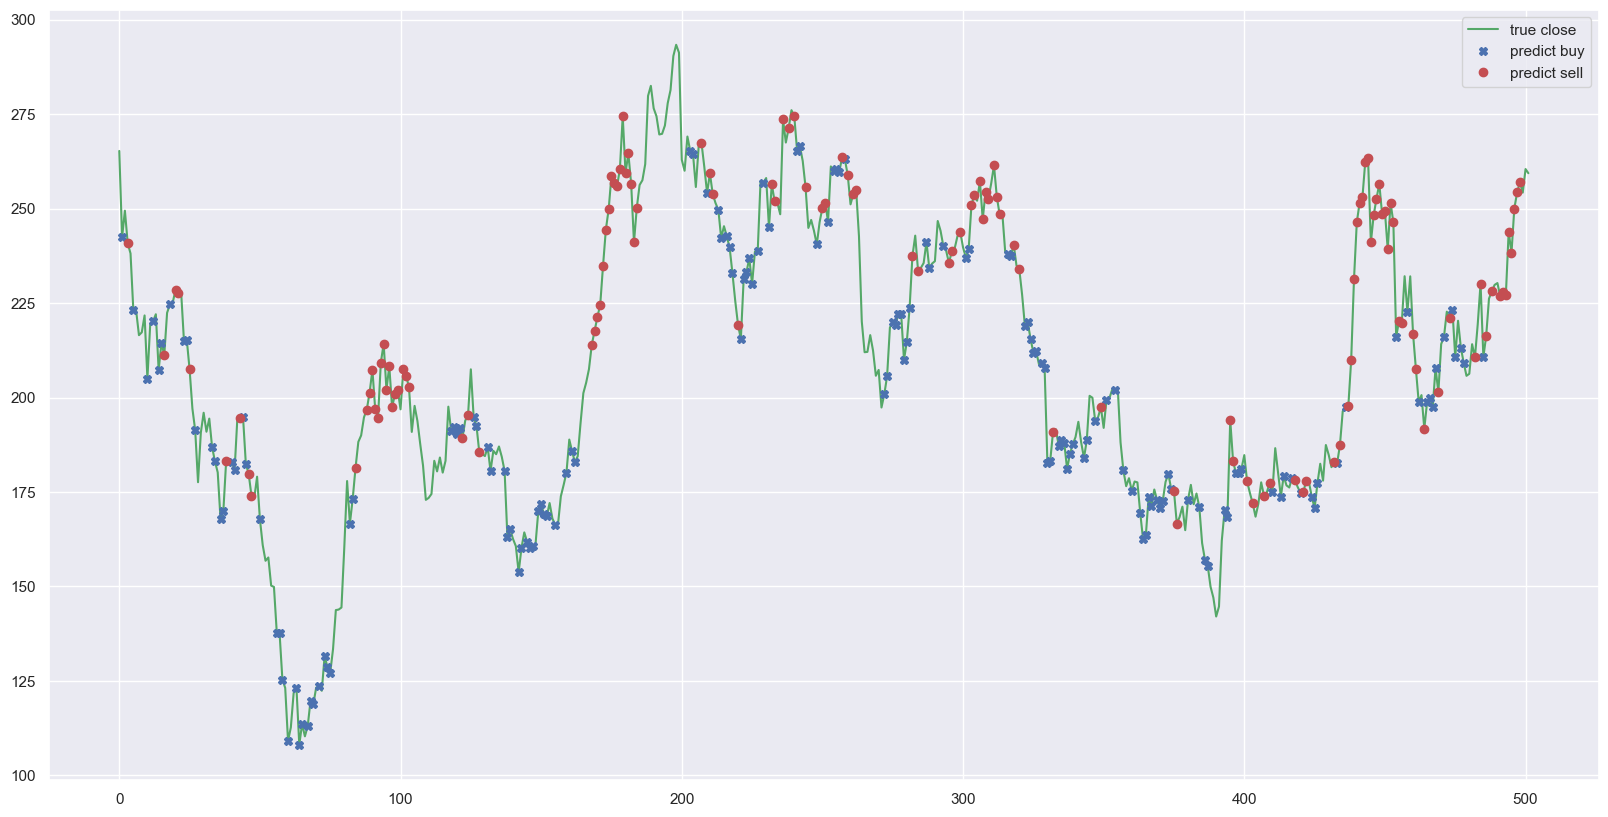

In [22]:
agent.buy()